<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

In [2]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../sdc/webscraping/letter_data_test_{i}.csv',
        index_col=0
    ) for i in range(15)
])

print('number of null disposition dates: ', sdc_data['Disposition Date'].isnull().sum())
sdc_data['time_step'] = sdc_data['Disposition Date'].fillna(sdc_data['Filed'])

sdc_data = sdc_data[sdc_data.index != -1]
sdc_data = sdc_data[sdc_data.Charge.notnull() & sdc_data['Code Section'].notnull()]

sdc_data = sdc_data[sdc_data['Disposition Code'] == 'Guilty'].drop('Disposition Code', axis=1)


sdc_data['day'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[1]))
sdc_data['month'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[0]))
sdc_data['year'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[2]))
sdc_data.time_step = sdc_data.month + sdc_data.year * 12 + sdc_data.day / 365 * 12 - 2010 * 12

sdc_data['sentence_time'] = sdc_data['Sentence Time'].fillna('0')
sdc_data['sentence_suspended'] = sdc_data['Sentence Suspended'].fillna('0')

def clean_sentence_length(sentence_str):
    sentence = 0
    for date in sentence_str.split('(s)'):
        if 'Year' in date:
            sentence += float(date.split(' ')[0]) * 12
        if 'Month' in date:
            sentence += float(date.split(' ')[0])
        if 'Day' in date:
            sentence += float(date.split(' ')[0]) / 365 * 12
    return sentence

sdc_data['person_id'] = sdc_data.Defendant + sdc_data.DOB + sdc_data.Address

sdc_data['compartment_duration'] = \
    sdc_data.sentence_time.apply(clean_sentence_length) - sdc_data.sentence_suspended.apply(clean_sentence_length)


sdc_data = sdc_data.rename({
    'Code Section': 'CodeSection', 'Concurrent/Consecutive': 'ConcurrentConsecutive'
}, axis=1)

sdc_data.head()

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


number of null disposition dates:  120416


,Address,Amended Charge,Amended Charge Type,Amended Code Section,Arrest Date,Charge,Charge Type,Class,CodeSection,Commenced by,Concluded By,ConcurrentConsecutive,Costs,Court/DMV Surrender,DOB,Defendant,Disposition Date,Driver Improvement Clinic,Driving Restrictions,Filed,Fine Amount,Fines/Cost Paid,Jail/Penitentiary,Life/Death,Locality,Military,Offense Date,Operator License Suspension Time,Probation Starts,Probation Time,Probation Type,Program Type,Race,Restitution Amount,Restitution Paid,Sentence Suspended,Sentence Time,Sex,Traffic Fatality,VA Alcohol Safety Action,county,time_step,day,month,year,sentence_time,sentence_suspended,person_id,compartment_duration
0,SURRY[.] VA 23883,NaN,NaN,NaN,05/14/2020,OTHER FAIL TO REGIST[.] 2ND OFF,Felony,6,18.2-472.1,Indictment,Guilty Plea,NaN,$535.00,NaN,06/19/****,ABNEY[.] JUSTIN EUGENE,09/01/2021,NaN,NaN,03/18/2021,$0.00,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,01/29/2020,NaN,NaN,NaN,NaN,NaN,White,$0.00,NaN,5 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,141.032877,1,9,2021,5 Year(s),5 Year(s),ABNEY[.] JUSTIN EUGENE06/19/****SURRY[.] VA 23883,0.0
1,PETERSBURG[.]VA 23803,ACCOMODATION,Felony,18.2-248,NaN,DISTRIBUTE CLASS II DRUG,Felony,NaN,18.2-248,Direct Indictment,Guilty Plea,NaN,$2245.00,NaN,08/22/****,ADDISON[.] BOB IRVIN; JR,02/07/2007,NaN,NaN,09/25/2006,$0.00,Yes,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,11/24/2004,6 Month(s),NaN,99 Year(s)0 Month(s)0 Day(s),Supervised,NaN,White,$0.00,NaN,4 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,-33.769863,7,2,2007,5 Year(s),4 Year(s),ADDISON[.] BOB IRVIN; JR08/22/****PETERSBURG[....,12.0
4,PETERSBURG[.]VA 23803,ACCOMODATION,Felony,18.2-248,NaN,DISTRIBUTE CLASS II DRUG,Felony,NaN,18.2-248,Direct Indictment,Guilty Plea,NaN,NaN,NaN,08/22/****,ADDISON[.] BOB IRVIN; JR,02/07/2007,NaN,NaN,09/25/2006,NaN,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,12/09/2004,NaN,NaN,99 Year(s)0 Month(s)0 Day(s),Supervised,NaN,White,NaN,NaN,5 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,-33.769863,7,2,2007,5 Year(s),5 Year(s),ADDISON[.] BOB IRVIN; JR08/22/****PETERSBURG[....,0.0
8,HAMPTON[.] VA 23669,NaN,NaN,NaN,07/09/2018,ASSAULT,Misdemeanor,1,18.2-57,General District Court Appeal,Trial - Judge With Witness,NaN,$53.00,NaN,05/08/****,ADKINSON[.] ERICA ANTRIVIA,02/06/2019,NaN,NaN,10/02/2018,$0.00,Yes,Jail,NaN,COMMONWEALTH OF VA,NaN,07/08/2018,NaN,NaN,NaN,NaN,NaN,Black,NaN,NaN,3 Month(s),6 Month(s),Female,NaN,NaN,Surry Circuit Court,110.197260,6,2,2019,6 Month(s),3 Month(s),ADKINSON[.] ERICA ANTRIVIA05/08/****HAMPTON[.]...,3.0
10,HOPEWELL[.] VA 23860,NaN,NaN,NaN,10/09/2018,ENTER HOUSE TO COMMIT A&B ETC.,Felony,U,18.2-91,Indictment,Trial - Judge With Witness,NaN,$800.00,NaN,03/26/****,ALLEN[.] CHRISTOPHER T,11/06/2019,NaN,NaN,01/08/2019,$0.00,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,08/25/2018,NaN,NaN,NaN,NaN,NaN,White,$12791.56,NaN,6 Year(s)6 Month(s),10 Year(s),Male,NaN,NaN,Surry Circuit Court,119.197260,6,11,2019,10 Year(s),6 Year(s)6 Month(s),ALLEN[.] CHRISTOPHER T03/26/****HOPEWELL[.] VA...,42.0


In [3]:
sdc_data.county.unique()

array(['Surry Circuit Court', 'Prince George Circuit Court',
       'Shenandoah Circuit Court', 'Suffolk Circuit Court',
       'Roanoke City Circuit Court', 'York County/Poquoson Circuit Court',
       'Rockbridge Circuit Court', 'Warren Circuit Court',
       'Wythe Circuit Court', 'Spotsylvania Circuit Court',
       'Roanoke County Circuit Court', 'Virginia Beach Circuit Court',
       'Page Circuit Court', 'Lunenburg Circuit Court',
       'Southampton Circuit Court', 'Smyth Circuit Court',
       'Wise Circuit Court', 'Tazewell Circuit Court',
       'Richmond County Circuit Court', 'Scott Circuit Court',
       'Sussex Circuit Court', 'Winchester Circuit Court',
       'Salem Circuit Court', 'Prince William Circuit Court',
       'Russell Circuit Court',
       'Williamsburg/James City County Circuit Court',
       'Staunton Circuit Court', 'Richmond City Circuit Court',
       'Nelson Circuit Court', 'Stafford Circuit Court',
       'Prince Edward Circuit Court', 'Isle of Wight

In [ ]:
circuit_densities = {
    'Suffolk Circuit Court': 94324 / 400,
    'Roanoke City Circuit Court': 100011 / 43,
    'York County/Poquoson Circuit Court': (70045 + 12460) / (106 + 16),
    'Virginia Beach Circuit Court': 459470 / 248,
    'Winchester Circuit Court': 28120 / 9,
    'Salem Circuit Court': 25346 / 15,
    'Williamsburg/James City County Circuit Court': (78254 + 15425 )/ (143 + 9),
    'Staunton Circuit Court': 25750 / 20,
    'Richmond City Circuit Court': 226610 / 60,
    'Radford Circuit Court': 16070 / 10,
    'Waynesboro Circuit Court': 22196 / 14,
    'Portsmouth Circuit Court': 97915 / 33,
    'Norfolk Circuit Court': 238005 / 54,
    'Petersburg Circuit Court': 33458 / 23,
    'Chesapeake Circuit Court': 249422 / 341,
    'Danville Circuit Court': 42590 / 43,
    'Martinsville Circuit Court': 13485 / 11,
    'Newport News Circuit Court': 186247 / 68,
    'Hopewell Circuit Court': 23033 / 10,
    'Buena Vista Circuit Court': 6641 / 7,
    'Bristol Circuit Court': 17219 / 12,
    'Charlottesville Circuit Court': 46553 / 10,
    'Colonial Heights Circuit Court': 18170 / 8,
    'Fredericksburg Circuit Court': 27982 / 10,
    'Surry Circuit Court': 6561 / 279,
    'Prince George Circuit Court': 43010 / 266,
    'Shenandoah Circuit Court': 44186 / 512,
    'Rockbridge Circuit Court': 22650 / 600,
    'Warren Circuit Court': 40727 / 214,
    'Wythe Circuit Court': 28290 / 463,
    'Spotsylvania Circuit Court': 140032 / 401,
    'Roanoke County Circuit Court': 96929 / 251,
    'Page Circuit Court': 23709 / 311,
    'Lunenburg Circuit Court': 11936 / 432,
    'Southampton Circuit Court': 17966 / 600,
    'Smyth Circuit Court': 29800 / 452,
    'Wise Circuit Court': 36130 / 403,
    'Tazewell Circuit Court': 40429 / 520,
    'Richmond County Circuit Court': 8923 / 192,
    'Scott Circuit Court': 21576 / 527,
    'Sussex Circuit Court': 10829 / 491,
    'Prince William Circuit Court': 482209 / 338,
    'Russell Circuit Court': 25781 / 475,
    'Nelson Circuit Court': 14775 / 472,
    'Stafford Circuit Court': 156927 / 720,
    'Prince Edward Circuit Court': 21849 / 353,
    'Isle of Wight Circuit Court': 38606 / 316,
    'Rappahannock Circuit Court': 7348 / 267,
    'Westmoreland Circuit Court': 18477 / 229,
    'Rockingham Circuit Court': 83757 / 851,
    'Orange Circuit Court': 34254 / 342,
    'Powhatan Circuit Court': 30333 / 261,
    'Pulaski Circuit Court': 33800 / 321,
    'Washington Circuit Court': 53935 / 564,
    'Nottoway Circuit Court': 15642 / 315,
    'Montgomery Circuit Court': 99721 / 388,
    'Northumberland Circuit Court': 11839 / 192,
    'Louisa Circuit Court': 37596 / 498,
    'Northampton Circuit Court': 12282 / 207,
    'Middlesex Circuit Court': 10625 / 130,
    'Loudoun Circuit Court': 420959 / 420,
    'Pittsylvania Circuit Court': 60501 / 978,
    'Mecklenburg Circuit Court': 30319 / 624,
    'Lee Circuit Court': 22173 / 437,
    'Greensville Circuit Court': 11391 / 296,
    'Buckingham Circuit Court': 16824 / 581,
    'Augusta Circuit Court': 77487 / 971,
    'Mathews Circuit Court': 8533 / 86,
    'Lancaster Circuit Court': 10919 / 133,
    'Patrick Circuit Court': 17608 / 483,
    'King William Circuit Court': 17810 / 275,
    'New Kent Circuit Court': 22945 / 210,
    'Greene Circuit Court': 2552 / 157,
    'Buchanan Circuit Court': 2355 / 504,
    'Grayson Circuit Court': 15333 / 443,
    'Arlington Circuit Court': 238643 / 26,
    'Highland Circuit Court': 2232 / 406,
    'Henry Circuit Court': 50948 / 382,
    'King George Circuit Court': 26723 / 180,
    'Madison Circuit Court': 13837 / 322,
    'Goochland Circuit Court': 24727 / 284,
    'Fluvanna Circuit Court': 27249 / 287,
    'Bath Circuit Court': 4209 / 532,
    'Accomack Circuit Court': 33413 / 455,
    'Chesterfield Circuit Court': 364548 / 426,
    'Bedford Circuit Court': 79462 / 755,
    'Campbell Circuit Court': 55696 / 504,
    'Dickenson Circuit Court': 14124 / 333,
    'Albemarle Circuit Court': 112395 / 723,
    'Dinwiddie Circuit Court': 27947 / 504,
    'Bland Circuit Court': 6270 / 359,
    'Alleghany Circuit Court': 15223 / 436,
    'Botetourt Circuit Court': 33596 / 543,
    'Amelia Circuit Court': 13265 / 357,
    'Caroline Circuit Court': 30887 / 533,
    'Amherst Circuit Court': 31307 / 475,
    'Carroll Circuit Court': 29155 / 476,
    'Appomattox Circuit Court': 16119 / 334,
    'Brunswick Circuit Court': 15849 / 566,
    'Charles City Circuit Court': 6773 / 182,
    'Charlotte Circuit Court': 11529 / 475,
    'Essex Circuit Court': 10599 / 258,
    'Hampton Circuit Court': 137148 / 52,
    'Fauquier Circuit Court': 72972 / 650,
    'Clarke Circuit Court': 14783 / 177,
    'Floyd Circuit Court': 15476 / 382,
    'Craig Circuit Court': 4892 / 330,
    'Culpeper Circuit Court': 52552 / 381,
    'Frederick Circuit Court': 91419 / 415,
    'Cumberland Circuit Court': 9675 / 298,
    'Giles Circuit Court': 16787 / 358,
    'Gloucester Circuit Court': 38711 / 217,
    'Halifax Circuit Court': 34022 / 814,
    'Hanover Circuit Court': 109979 / 743,
    'Lynchburg Circuit Court': 79009 / 49,
    'Henrico Circuit Court': 334389 / 238,
    'Clifton Forge Circuit Court': 3884 / 3,
    'Franklin Circuit Court':  (54477 + 8180) / (692 + 8)
}

In [ ]:
cities = [
    'Suffolk Circuit Court',
    'Roanoke City Circuit Court',
    'York County/Poquoson Circuit Court'
    'Virginia Beach Circuit Court',
    'Winchester Circuit Court',
    'Salem Circuit Court',
    'Williamsburg/James City County Circuit Court',
    'Staunton Circuit Court',
    'Richmond City Circuit Court',
    'Radford Circuit Court',
    'Waynesboro Circuit Court',
    'Portsmouth Circuit Court',
    'Norfolk Circuit Court',
    'Petersburg Circuit Court',
    'Chesapeake Circuit Court',
    'Danville Circuit Court',
    'Martinsville Circuit Court',
    'Newport News Circuit Court',
    'Hopewell Circuit Court',
    'Buena Vista Circuit Court',
    'Bristol Circuit Court',
    'Charlottesville Circuit Court',
    'Colonial Heights Circuit Court',
    'Fredericksburg Circuit Court',
]
non_city_counties = [
    'Surry Circuit Court',
    'Prince George Circuit Court',
    'Shenandoah Circuit Court',
    'Rockbridge Circuit Court',
    'Warren Circuit Court',
    'Wythe Circuit Court',
    'Spotsylvania Circuit Court',
    'Roanoke County Circuit Court',
    'Page Circuit Court',
    'Lunenburg Circuit Court',
    'Southampton Circuit Court',
    'Smyth Circuit Court',
    'Wise Circuit Court',
    'Tazewell Circuit Court',
    'Richmond County Circuit Court',
    'Scott Circuit Court',
    'Sussex Circuit Court',
    'Prince William Circuit Court',
    'Russell Circuit Court',
    'Nelson Circuit Court',
    'Stafford Circuit Court',
    'Prince Edward Circuit Court',
    'Isle of Wight Circuit Court',
    'Rappahannock Circuit Court',
    'Westmoreland Circuit Court',
    'Rockingham Circuit Court',
    'Orange Circuit Court',
    'Powhatan Circuit Court',
    'Pulaski Circuit Court',
    'Washington Circuit Court',
    'Nottoway Circuit Court',
    'Montgomery Circuit Court',
    'Northumberland Circuit Court',
    'Louisa Circuit Court',
    'Northampton Circuit Court',
    'Middlesex Circuit Court',
    'Loudoun Circuit Court',
    'Pittsylvania Circuit Court',
    'Mecklenburg Circuit Court',
    'Lee Circuit Court',
    'Greensville Circuit Court',
    'Buckingham Circuit Court',
    'Augusta Circuit Court',
    'Mathews Circuit Court',
    'Lancaster Circuit Court',
    'Patrick Circuit Court',
    'King William Circuit Court',
    'New Kent Circuit Court',
    'Greene Circuit Court',
    'Buchanan Circuit Court',
    'Grayson Circuit Court',
    'Arlington Circuit Court',
    'Highland Circuit Court',
    'Henry Circuit Court',
    'King George Circuit Court',
    'Madison Circuit Court',
    'Goochland Circuit Court',
    'Fluvanna Circuit Court',
    'Bath Circuit Court',
    'Accomack Circuit Court',
    'Chesterfield Circuit Court',
    'Bedford Circuit Court',
    'Campbell Circuit Court',
    'Dickenson Circuit Court',
    'Albemarle Circuit Court',
    'Dinwiddie Circuit Court',
    'Bland Circuit Court',
    'Alleghany Circuit Court',
    'Botetourt Circuit Court',
    'Amelia Circuit Court',
    'Caroline Circuit Court',
    'Amherst Circuit Court',
    'Carroll Circuit Court',
    'Appomattox Circuit Court',
    'Brunswick Circuit Court',
    'Charles City Circuit Court',
    'Charlotte Circuit Court',
    'Essex Circuit Court',
    'Hampton Circuit Court',
    'Fauquier Circuit Court',
    'Clarke Circuit Court',
    'Floyd Circuit Court',
    'Craig Circuit Court',
    'Culpeper Circuit Court',
    'Frederick Circuit Court',
    'Cumberland Circuit Court',
    'Giles Circuit Court',
    'Gloucester Circuit Court',
    'Halifax Circuit Court',
    'Hanover Circuit Court',
    'Lynchburg Circuit Court',
    'Henrico Circuit Court',
    'Clifton Forge Circuit Court'
]

unclears = [
    'Franklin Circuit Court',
]

<AxesSubplot:xlabel='year'>

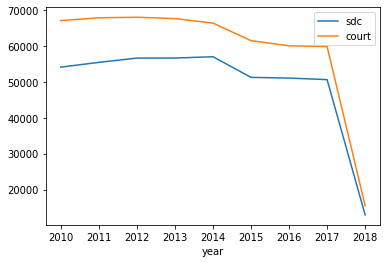

In [72]:
sdc_overlap = sdc_data[(sdc_data.time_step > 0) & (sdc_data.time_step < 100)]
court_overlap = court_data[(court_data.time_step > 0) & (court_data.time_step < 100)]

display_df = pd.DataFrame()
display_df['sdc'] = sdc_overlap.groupby('year').count().max(axis=1)
display_df['court'] = court_overlap.groupby('year').count().max(axis=1)
display_df.iloc[1:].plot()

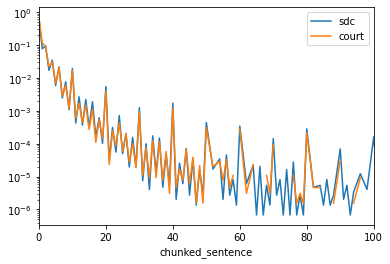

In [85]:
chunk_size = 6 # months

sdc_data['chunked_sentence'] = (sdc_data.compartment_duration / chunk_size).apply(round)
court_data['chunked_sentence'] = (court_data.effective_sentence_months / chunk_size).apply(round)

compare_df = pd.DataFrame()
compare_df['sdc'] = sdc_data.groupby('chunked_sentence').count().max(axis=1) / len(sdc_data)
compare_df['court'] = court_data.groupby('chunked_sentence').count().max(axis=1) / len(court_data)
compare_df.plot(xlim=[0,100])
plt.yscale('log')

<AxesSubplot:xlabel='chunked_sentence'>

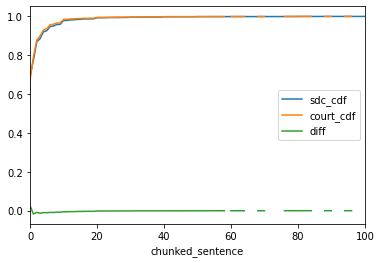

In [87]:
compare_df['sdc_cdf'] = compare_df.sdc.cumsum()
compare_df['court_cdf'] = compare_df.court.cumsum()
compare_df['diff'] = compare_df.sdc_cdf - compare_df.court_cdf
compare_df[['sdc_cdf', 'court_cdf', 'diff']].plot(xlim=[0,100])

In [89]:
compare_df['diff'].mean()

-0.0016795508126407758